In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from subhalo_count import *

# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('/home/aussing/sty.mplstyle')

In [3]:
UNITMASS = 1e10
LITTLEH = 0.6688
UNIT_LENGTH_FOR_PLOTS = 'Mpc'
npart_min = 20
npart_star_min = 1


In [4]:

def get_extent(halo_pos,extent):

    xmin,xmax  = halo_pos[0]-extent,halo_pos[0]+extent
    ymin,ymax  = halo_pos[1]-extent,halo_pos[1]+extent
    zmin,zmax  = halo_pos[2]-extent,halo_pos[2]+extent
    
    return xmin,xmax,ymin,ymax,zmin,zmax


In [5]:

def make_mask(pos_x,pos_y,pos_z,halo_pos,extent):
    xmin,xmax,ymin,ymax,zmin,zmax = get_extent(halo_pos,extent)
    
    x_mask = (pos_x>=xmin) & (pos_x<=xmax)
    y_mask = (pos_y>=ymin) & (pos_y<=ymax)
    z_mask = (pos_z>=zmin) & (pos_z<=zmax)
    
    pos_mask = x_mask & y_mask & z_mask

    return pos_mask

In [6]:
def get_sim_data(sim_directory,n_file):
    snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(n_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = np.round(snap_data['Header'].attrs['Redshift'],2)
    return snap_data, haloinfo_data, z

In [7]:
def subhalo_data(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    z = np.round(z,2)
    # print(z)
    # unit_len = get_unit_len(snap_data)

    halo_pos   = np.array(haloinfo_data['Group']['GroupPos'], dtype=np.float64) #/ LITTLEH
    halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH
    R200c = np.array(haloinfo_data['Group']['Group_R_Crit200'], dtype=np.float64) #/ LITTLEH
    # Rvir = np.array(haloinfo_data['Group']['Group_R_VIR'], dtype=np.float64) 

    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0]

    # print(f"Redshift = {np.round(z,2)}")
    # print(f"main halo ID = {mass_mask[halo_mainID]}")
    # print(f"Main halo pos = {halo_pos[mass_mask[halo_mainID],:]*LITTLEH}")
    # print(f'M_200c = {np.round(halo_M200c[mass_mask[halo_mainID]]/1e10,3)*LITTLEH}e10 h^-1 Msun')
    # print(f"R_200c = {np.round((R200c[mass_mask[halo_mainID]]),4)*LITTLEH} {UNIT_LENGTH_FOR_PLOTS}") # *unit_len set_plot_len

    main_halo_only = True
    subhalo_halo_num = np.array(haloinfo_data['Subhalo']['SubhaloGroupNr'], dtype=np.float64)
    subhalo_rank       = np.array(haloinfo_data['Subhalo']['SubhaloRankInGr'], dtype=np.int32)

    subhalo_mass       = np.array(haloinfo_data['Subhalo']['SubhaloMass'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_mass_type  = np.array(haloinfo_data['Subhalo']['SubhaloMassType'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_len        = np.array(haloinfo_data['Subhalo']['SubhaloLen'],dtype=np.int32)
    subhalo_len_type   = np.array(haloinfo_data['Subhalo']['SubhaloLenType'],dtype=np.int32)
    subhalo_pos        = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) #/ LITTLEH 

    main_halo_subhalos = np.where(subhalo_halo_num==[mass_mask[halo_mainID]])

    subhalo_mass       = subhalo_mass[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    subhalo_mass_type  = subhalo_mass_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len        = subhalo_len[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len_type   = subhalo_len_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 

    # subhalo_pos = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 
    subhalo_pos = subhalo_pos[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    # subhalo_pos_dif = subhalo_pos - halo_pos[mass_mask[halo_mainID],:]
    # print(f"subhalo rank 0 - {subhalo_pos[0,:]}")
    # print(f"subhalo rank 1 - {subhalo_pos[1,:]}\n")

    subhalo_dist = []
    for i in range(len(subhalo_pos)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = subhalo_pos[i] - halo_pos[mass_mask[halo_mainID],:]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))

    subhalo_dist = np.array(subhalo_dist)
    mask_dists = (subhalo_dist>0.01) #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))
    # print(subhalo_dist[mask_dists])
    test = subhalo_dist[mask_dists]

    mask = (subhalo_len>=npart_min) & (subhalo_len_type[:,4]>=npart_star_min) & (subhalo_dist>0.005)  #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))

    # print(mask)
    star_mass              = subhalo_mass_type[mask,4]
    star_mass_ordered      = np.argsort(star_mass)[::-1]
    star_mass              = star_mass[star_mass_ordered][np.where(star_mass[star_mass_ordered]>0)[0]]
    star_mass_sum          = np.cumsum(np.ones(star_mass.shape[0]))
    
    subhalo_radius = np.array(haloinfo_data['Subhalo']['SubhaloHalfmassRad'],dtype=np.float64) #/ LITTLEH #* unit_len
    subhalo_radius = subhalo_radius[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    
    return halo_pos[mass_mask[halo_mainID],:], halo_M200c[mass_mask[halo_mainID]], halo_mass[mass_mask[halo_mainID]], z, subhalo_pos, subhalo_radius, R200c[mass_mask[halo_mainID]], subhalo_mass_type

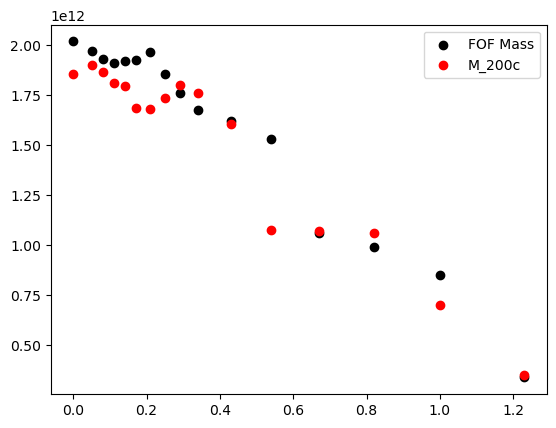

In [14]:
folder  = 'N2048_L65_sd00372'
# folder  = 'N2048_L65_sd03157'

# folder  = 'N2048_L65_sd02640'
# folder  = 'N2048_L65_sd17492'

# folder  = 'N2048_L65_sd28504'
# folder  = 'N2048_L65_sd34920'
# folder  = 'N2048_L65_sd46371'
# folder  = 'N2048_L65_sd57839'
# folder  = 'N2048_L65_sd61284'
# folder  = 'N2048_L65_sd70562'
# folder  = 'N2048_L65_sd80325'
# folder  = 'N2048_L65_sd93745'

sim_directory_cdm_005 = f'/fred/oz217/aussing/{folder}/cdm/zoom/output/sn_005/'
sim_directory_cdm_010 = f'/fred/oz217/aussing/{folder}/cdm/zoom/output/sn_010/'

sim_directory_wdm_005 = f'/fred/oz217/aussing/{folder}/wdm_3.5/zoom/output/sn_005/'
sim_directory_wdm_010 = f'/fred/oz217/aussing/{folder}/wdm_3.5/zoom/output/sn_010/'
i_file = 26
redshift = np.linspace(10,26,16,dtype=int)
for snap in redshift:
    try:
        # halo_pos_cdm_005, halo_m200c_cdm_005, halo_mass_cdm_005, z, subhalo_pos_cdm_005, subhalo_radius_cdm_005, r_200c_cdm_005, subhalo_mass_type_cdm_005 = subhalo_data(sim_directory_cdm_005,snap)
        halo_pos_cdm_010, halo_m200c_cdm_010, halo_mass_cdm_010, z, subhalo_pos_cdm_010, subhalo_radius_cdm_010, r_200c_cdm_010, subhalo_mass_type_cdm_010 = subhalo_data(sim_directory_cdm_010,snap)

        halo_pos_wdm_005, halo_m200c_wdm_005, halo_mass_wdm_005, z, subhalo_pos_wdm_005, subhalo_radius_wdm_005, r_200c_wdm_005, subhalo_mass_type_wdm_005 = subhalo_data(sim_directory_wdm_005,snap)
        # halo_pos_wdm_010, halo_m200c_wdm_010, halo_mass_wdm_010, z, subhalo_pos_wdm_010, subhalo_radius_wdm_010, r_200c_wdm_010, subhalo_mass_type_wdm_010 = subhalo_data(sim_directory_wdm_010,snap)
        # if snap in [14,16,17,18]:
        #     plt.scatter(halo_pos_cdm_010[0],halo_pos_cdm_010[1],s=20)
        #     plt.scatter(subhalo_pos_cdm_010[0,0],subhalo_pos_cdm_010[0,1],s=15)
        # else:
        #     plt.scatter(halo_pos_cdm_010[0],halo_pos_cdm_010[1],c='k',s=10)
        #     plt.scatter(subhalo_pos_cdm_010[0,0],subhalo_pos_cdm_010[0,1],c='r',s=5)
        # print(z, halo_pos_cdm_010)
        # print(z, subhalo_pos_cdm_010[0])
        plt.scatter(z,halo_mass_cdm_010,c='k')
        plt.scatter(z,halo_m200c_cdm_010,c='r')
        # plt.scatter(halo_pos_cdm_010[1],halo_pos_cdm_010[2],c='r')
    except:
        print('aa')
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel('Redshift')
    # plt.ylabel("R_200c  [Kpc/h]")
    plt.legend(('FOF Mass', 'M_200c'))

# plt.close()


aa
aa
aa
aa
aa
aa
aa
aa
aa
aa


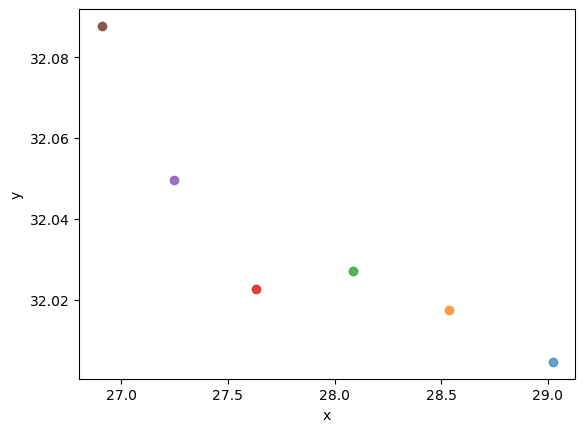

In [9]:
alpha_list = np.linspace(0,1,len(redshift))
for snap in redshift:
    try:
        halo_pos_cdm_005, halo_m200c_cdm_005, halo_mass_cdm_005, z, subhalo_pos_cdm_005, subhalo_radius_cdm_005, r_200c_cdm_005, subhalo_mass_type_cdm_005 = subhalo_data(sim_directory_cdm_005,snap)
        halo_pos_cdm_010, halo_m200c_cdm_010, halo_mass_cdm_010, z, subhalo_pos_cdm_010, subhalo_radius_cdm_010, r_200c_cdm_010, subhalo_mass_type_cdm_010 = subhalo_data(sim_directory_cdm_010,snap)

        halo_pos_wdm_005, halo_m200c_wdm_005, halo_mass_wdm_005, z, subhalo_pos_wdm_005, subhalo_radius_wdm_005, r_200c_wdm_005, subhalo_mass_type_wdm_005 = subhalo_data(sim_directory_wdm_005,snap)
        halo_pos_wdm_010, halo_m200c_wdm_010, halo_mass_wdm_010, z, subhalo_pos_wdm_010, subhalo_radius_wdm_010, r_200c_wdm_010, subhalo_mass_type_wdm_010 = subhalo_data(sim_directory_wdm_010,snap)
        # plt.scatter(halo_pos_cdm_010[0],halo_pos_cdm_010[1])
        # print(snap, z, halo_pos_cdm_010 , halo_m200c_cdm_010/UNITMASS)
        # print(snap, z, subhalo_pos_cdm_010[0], len(subhalo_mass_type_cdm_005[:,0]))
        # print()
        plt.scatter(halo_pos_cdm_010[0],halo_pos_cdm_010[1],alpha=alpha_list[snap])
        # plt.scatter(z,halo_m200c_cdm_010,c='g')
        # plt.scatter(z,np.sum(subhalo_mass_type_cdm_010[:,0]),c='k')
        # plt.scatter(z,np.sum(subhalo_mass_type_cdm_010[:,1]),c='r')
        # plt.scatter(z,np.sum(subhalo_mass_type_cdm_010[:,4]),c='b')
        # plt.yscale('log')
        plt.xlabel('x')
        plt.ylabel('y')
    except:
        print('aa')

[ 0  1  2  3  4  5  6  8 10 19 20 21 32]


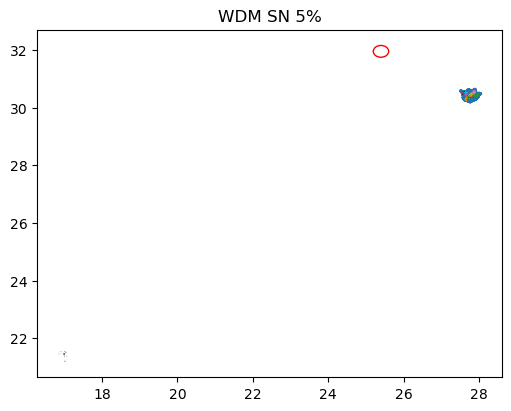

In [10]:
sim_dir_wdm_sn_005 = '/fred/oz217/aussing/N2048_L65_sd17492/wdm_3.5/zoom/output/sn_005/'

snap_data_wdm_sn_005, haloinfo_data_wdm_sn_005, z = get_sim_data(sim_dir_wdm_sn_005,i_file)

snap_ids_dm_wdm_sn_005 = snap_data_wdm_sn_005['PartType1']['ParticleIDs']
dm_pos_wdm_sn_005 = snap_data_wdm_sn_005['PartType1']['Coordinates']
gas_pos_wdm_sn_005 = snap_data_wdm_sn_005['PartType0']['Coordinates']
star_pos_wdm_sn_005 = snap_data_wdm_sn_005['PartType4']['Coordinates']

subhalo_offset_type_wdm_sn_005 =  np.array(haloinfo_data_wdm_sn_005['Subhalo']['SubhaloOffsetType'], dtype=np.int64)
stel_subhalos_wdm_sn_005 = np.where(subhalo_mass_type_wdm_005[:,4]>0)[0]#+1
print(stel_subhalos_wdm_sn_005)
fig, ax1 = plt.subplots(1,1,figsize=(5,4),dpi=100,layout='constrained')

sub_id_all_list_wdm_sn_005 = []
for i in stel_subhalos_wdm_sn_005:
# for i in range(1,len(subhalo_mass_type_wdm_005)-1,1):
# for i in range(1,2,1):
    sub_id_list = snap_ids_dm_wdm_sn_005[subhalo_offset_type_wdm_sn_005[i,1]:subhalo_offset_type_wdm_sn_005[(i+1),1]]
    sub_id_all_list_wdm_sn_005 = np.hstack((np.unique(sub_id_all_list_wdm_sn_005),sub_id_list))

    dm_pos_sub_wdm_sn_005 = dm_pos_wdm_sn_005[subhalo_offset_type_wdm_sn_005[i,1]:subhalo_offset_type_wdm_sn_005[(i+1),1]]
    plt.scatter(dm_pos_sub_wdm_sn_005[:,0],dm_pos_sub_wdm_sn_005[:,1], s=0.05,alpha=0.8,marker='.')
    
    star_pos_sub_wdm_sn_005 = star_pos_wdm_sn_005[subhalo_offset_type_wdm_sn_005[i,4]:subhalo_offset_type_wdm_sn_005[(i+1),4]]
    # plt.scatter(star_pos_sub[:,0],star_pos_sub[:,1], s=0.1,alpha=1,color='navy')

for i in stel_subhalos_wdm_sn_005-1:
# for i in range(0,len(subhalo_mass_type_cdm_010),1):
    ax1.add_patch(plt.Circle((subhalo_pos_wdm_005[i,0]*LITTLEH,subhalo_pos_wdm_005[i,1]*LITTLEH),subhalo_radius_wdm_005[i],fill=False,color='k',alpha=0.6,linewidth=0.5))

ax1.add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='red',alpha=1))
plt.title('WDM SN 5%')

# sub_id_all_list_wdm_sn_005 = sub_id_all_list_wdm_sn_005[sub_id_all_list_wdm_sn_005>0]
reduced_id_list_wdm_sn_005 = np.isin(snap_ids_dm_wdm_sn_005,sub_id_all_list_wdm_sn_005)


n= 0
percentage in each wdm subhalo =  [2.33878919e-01 6.17826859e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.97199763e-04]
new sum intersect =  4320
old bitmask sum =  4320
n= 1
percentage in each wdm subhalo =  [0.1518731  0.         0.69962875 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
new sum intersect =  2523
old bitmask sum =  2523
n= 2
percentage in each wdm subhalo =  [0.21467991 0.         0.         0.         0.68874172 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
new sum intersect =  1637
old bitmask sum =  1637
n= 3
percentage in each wdm subhalo =  [0.24950755 0.         0.         0.         0.         0.667761
 0.         0.         0.         0.         0.         0.
 0.        ]
new sum intersect =  1397
old bitmask sum =  1397
Percent WDM SN 5% in CDM SN 10% = 0.3 %
Perce

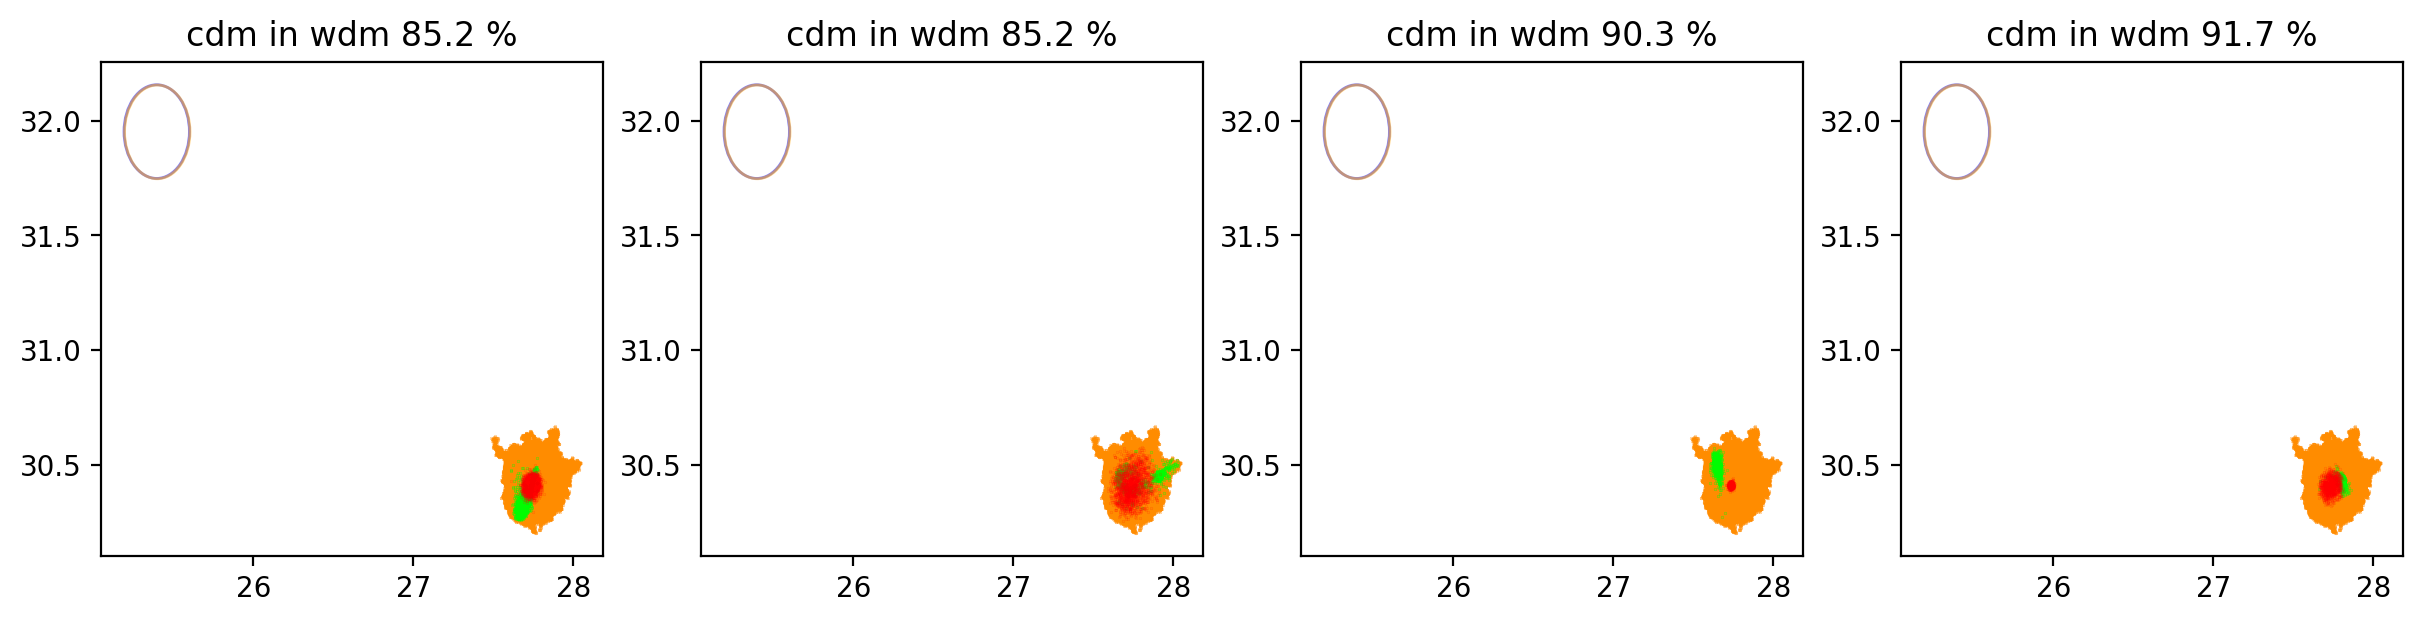

In [11]:

sim_dir_cdm_sn_010 = '/fred/oz217/aussing/N2048_L65_sd17492/cdm/zoom/output/sn_010/'
snap_data_cdm_sn_010, haloinfo_data_cdm_sn_010, z = get_sim_data(sim_dir_cdm_sn_010,i_file)

snap_ids_dm_cdm_sn_010 = snap_data_cdm_sn_010['PartType1']['ParticleIDs']
dm_pos_cdm_sn_010 = snap_data_cdm_sn_010['PartType1']['Coordinates']
gas_pos_cdm_sn_010 = snap_data_cdm_sn_010['PartType0']['Coordinates']
star_pos_cdm_sn_010 = snap_data_cdm_sn_010['PartType4']['Coordinates']

subhalo_offset_type_cdm_sn_010 =  np.array(haloinfo_data_cdm_sn_010['Subhalo']['SubhaloOffsetType'], dtype=np.int64)
stel_subhalos_cdm_sn_010 = np.where(subhalo_mass_type_cdm_010[:,4]>0)[0]+1


num_subs = 4
fig, axs = plt.subplots(1,num_subs,figsize=(12,3),dpi=200,layout='constrained')
for n in range(num_subs):
    print('n=',n)
    sub_id_all_list_cdm_sn_010 = np.zeros(1,dtype=np.int64)
    # for i in stel_subhalos_cdm_sn_010:
    # for i in range(1,len(subhalo_mass_type_cdm_010)-1,1):
    for i in range(n+1,n+2,1):
        # print('i= ',i)
        sub_id_list = snap_ids_dm_cdm_sn_010[subhalo_offset_type_cdm_sn_010[i,1]:subhalo_offset_type_cdm_sn_010[(i+1),1]]
        sub_id_all_list_cdm_sn_010 = np.hstack((np.unique(sub_id_all_list_cdm_sn_010),sub_id_list))

        dm_pos_sub_cdm_sn_010 = dm_pos_cdm_sn_010[subhalo_offset_type_cdm_sn_010[i,1]:subhalo_offset_type_cdm_sn_010[(i+1),1]]
        axs[n].scatter(dm_pos_sub_cdm_sn_010[:,0],dm_pos_sub_cdm_sn_010[:,1], s=0.05,alpha=0.8,marker='.')
        
        # star_pos_sub = star_pos_cdm_sn_010[subhalo_offset_type_cdm_sn_010[i,4]:subhalo_offset_type_cdm_sn_010[(i+1),4]]
        # plt.scatter(star_pos_sub[:,0],star_pos_sub[:,1], s=0.1,alpha=1,color='navy')


    sub_id_all_list_cdm_sn_010 = sub_id_all_list_cdm_sn_010[sub_id_all_list_cdm_sn_010>0] # actual IDs
    reduced_id_list_cdm_sn_010 = np.isin(snap_ids_dm_cdm_sn_010,sub_id_all_list_cdm_sn_010) # bitmask for CDM subhaloes
    wdm_sn_5_in_cdm_sn_10_sub_sub = np.isin(sub_id_all_list_wdm_sn_005,sub_id_all_list_cdm_sn_010) # bitmask WDM in CDM
    cdm_sn_10_in_wdm_sn_5_sub_sub = np.isin(sub_id_all_list_cdm_sn_010,sub_id_all_list_wdm_sn_005) # bitmask CDM in WDM
    
    # print('length id list = ',len(sub_id_all_list_cdm_sn_010))
    # print('sum cdm in wdm subs =', np.sum(cdm_sn_10_in_wdm_sn_5_sub_sub))
    
    axs[n].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005], s=0.05,alpha=1,marker='.',color='darkorange')
    
    sum_total_part_intersect = []

    for x in stel_subhalos_wdm_sn_005:
        new_sub_id_list = snap_ids_dm_wdm_sn_005[subhalo_offset_type_wdm_sn_005[x,1]:subhalo_offset_type_wdm_sn_005[(x+1),1]] # get all WDM subhalo PIDs
        new_reduced_list = np.isin(sub_id_all_list_cdm_sn_010,new_sub_id_list) # Checking intersection with CDM subhalo PIDs, gives length of intersect

        if np.sum(new_reduced_list) > 0 :
            small_cdm_part_list = sub_id_all_list_cdm_sn_010[new_reduced_list]
            test_list = np.isin(snap_ids_dm_wdm_sn_005,small_cdm_part_list) # re - getting the PIDs for this particular WDM subhalo
            # new_wdm_id_list = snap_ids_dm_wdm_sn_005[test_list]
            # better_test_list = np.isin(new_wdm_id_list,sub_id_all_list_cdm_sn_010)
        
            # print('test_list = ',np.sum(test_list))
            axs[n].scatter(dm_pos_wdm_sn_005[:,0][test_list],dm_pos_wdm_sn_005[:,1][test_list], s=0.05,alpha=1,marker='.',color='lime')
        
        # print(np.sum(new_reduced_list))
        # print(np.sum(new_reduced_list)/len(sub_id_all_list_cdm_sn_010)*100)
        sum_total_part_intersect.append(np.sum(new_reduced_list))
    
    sum_total_part_intersect = np.array(sum_total_part_intersect)
    print('percentage in each wdm subhalo = ',sum_total_part_intersect/len(sub_id_all_list_cdm_sn_010))
    print('new sum intersect = ',np.sum(sum_total_part_intersect))
    print('old bitmask sum = ',np.sum(wdm_sn_5_in_cdm_sn_10_sub_sub))

    

    axs[n].scatter(dm_pos_wdm_sn_005[:,0][reduced_id_list_wdm_sn_005][wdm_sn_5_in_cdm_sn_10_sub_sub],dm_pos_wdm_sn_005[:,1][reduced_id_list_wdm_sn_005][wdm_sn_5_in_cdm_sn_10_sub_sub], s=0.05,alpha=0.4,marker='.',c='red')
    
    # axs[n].scatter(dm_pos_cdm_sn_010[:,0][reduced_id_list_cdm_sn_010][cdm_sn_10_in_wdm_sn_5_sub_sub],dm_pos_cdm_sn_010[:,1][reduced_id_list_cdm_sn_010][cdm_sn_10_in_wdm_sn_5_sub_sub], s=0.05,alpha=0.4,marker='.',color='red')

    axs[n].add_patch(plt.Circle((halo_pos_cdm_010[0],halo_pos_cdm_010[1]),r_200c_cdm_010, fill=False,color='blue',alpha=0.5))
    axs[n].add_patch(plt.Circle((halo_pos_wdm_005[0],halo_pos_wdm_005[1]),r_200c_wdm_005, fill=False,color='orange',alpha=0.5))
    axs[n].set_title(f'cdm in wdm {np.round(np.sum(cdm_sn_10_in_wdm_sn_5_sub_sub)/len(cdm_sn_10_in_wdm_sn_5_sub_sub)*100,1)} %')

# plt.title('Shared')

# print(f'Num particles in subhaloes for cdm sn 5%  = {len(sub_id_all_list_cdm_sn_005)}')
# print(f'Num particles in subhaloes for cdm sn 10% = {len(sub_id_all_list_cdm_sn_010)}')
# print(f'Num particles in subhaloes for wdm sn 5%  = {len(sub_id_all_list_wdm_sn_005)}')
# print(f'Num particles in subhaloes for wdm sn 10% = {len(sub_id_all_list_wdm_sn_010)}\n')

print(f'Percent WDM SN 5% in CDM SN 10% = {np.round(np.sum(wdm_sn_5_in_cdm_sn_10_sub_sub)/len(wdm_sn_5_in_cdm_sn_10_sub_sub)*100,1)} %')
print(f'Percent CDM SN 10% in WDM SN 5% = {np.sum(cdm_sn_10_in_wdm_sn_5_sub_sub)/len(cdm_sn_10_in_wdm_sn_5_sub_sub)*100}')


